In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_sleep_rand2_1000_200
overview file: results/bench1_sleep_rand2_1000_200/overview_res-2021-02-27_16-47-11.csv
experiment file: configs/bench1_sleep_rand2_1000_200.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60
5,1,10,res-2021-02-25_22-25-54,bench1_sleep_rand2_1000_200,bench1,False,60
6,1,15,res-2021-02-25_23-26-10,bench1_sleep_rand2_1000_200,bench1,False,60
7,1,20,res-2021-02-26_00-26-27,bench1_sleep_rand2_1000_200,bench1,False,60


In [4]:
batch_seconds = 300

# func used on each batch (part of a single experiment logs)
parse_cols_funcs = {
    'conc_window_average': lambda df: df['conc_window_average'].mean(),
    'average_ready_count': lambda df: df['ready_count'].mean(),
}

parse_res = []
for res_name in overview_df['res_name']:
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    parse_colds_res = parse_util.parse_batch_custom_funcs(df, batch_seconds, parse_cols_funcs)
    parse_res.append(parse_colds_res)

parse_res_df = pd.DataFrame(data=parse_res)
parse_res_df.head()

,conc_window_average_mean,conc_window_average_var,conc_window_average_se,average_ready_count_mean,average_ready_count_var,average_ready_count_se
0,0.574979,0.000213,0.010320,2.096667,0.009344,0.068354
1,0.621493,0.000079,0.006280,4.013535,0.002197,0.033141
2,0.660605,0.000064,0.005635,5.802796,0.001305,0.025548
3,0.686855,0.000095,0.006880,8.989530,0.017022,0.092256
4,0.693312,0.000009,0.002064,12.618635,0.000786,0.019821


In [5]:
overview_parsed_df = pd.concat([overview_df, parse_res_df], axis=1)
overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,average_ready_count_mean,average_ready_count_var,average_ready_count_se
0,1,1,res-2021-02-25_17-23-32,bench1_sleep_rand2_1000_200,bench1,False,60,0.574979,0.000213,0.010320,2.096667,0.009344,0.068354
1,1,2,res-2021-02-25_18-24-16,bench1_sleep_rand2_1000_200,bench1,False,60,0.621493,0.000079,0.006280,4.013535,0.002197,0.033141
2,1,3,res-2021-02-25_19-24-47,bench1_sleep_rand2_1000_200,bench1,False,60,0.660605,0.000064,0.005635,5.802796,0.001305,0.025548
3,1,5,res-2021-02-25_20-25-14,bench1_sleep_rand2_1000_200,bench1,False,60,0.686855,0.000095,0.006880,8.989530,0.017022,0.092256
4,1,7,res-2021-02-25_21-25-36,bench1_sleep_rand2_1000_200,bench1,False,60,0.693312,0.000009,0.002064,12.618635,0.000786,0.019821


In [6]:
# list all available columns
overview_parsed_df.columns

Index(['target', 'rps', 'res_name', 'request_func', 'workload_name', 'is_rps',
       'exp_time_mins', 'conc_window_average_mean', 'conc_window_average_var',
       'conc_window_average_se', 'average_ready_count_mean',
       'average_ready_count_var', 'average_ready_count_se'],
      dtype='object')

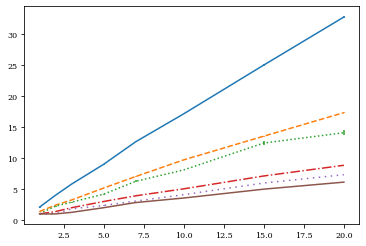

In [7]:
plt.figure()
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['average_ready_count_mean'])
    plt.errorbar(sub_df['rps'], sub_df['average_ready_count_mean'], yerr=sub_df['average_ready_count_se'])

parse_util.fix_log_x_plot()

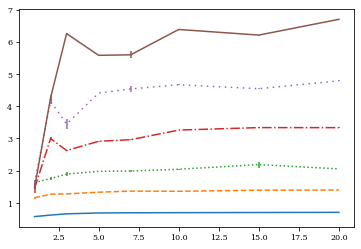

In [8]:
plt.figure()
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['conc_window_average_mean'], yerr=sub_df['conc_window_average_se'])

parse_util.fix_log_x_plot()